In [61]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box


In [2]:
def load_rgb_and_meta(filepath):
    """
    Loads a 3-band (RGB) Landsat 8 raster image, applies percentile stretch for visualisation,
    and extracts spatial extent and coordinate reference system (CRS).

    Parameters:
        filepath (str): Path to the raster file.

    Returns:
        tuple: (normalised RGB image as np.array, extent list [left, right, bottom, top], raster CRS)
    """
    with rasterio.open(filepath) as src:
        r = src.read(1).astype(np.float32)
        g = src.read(2).astype(np.float32)
        b = src.read(3).astype(np.float32)

        rgb = np.stack([r, g, b], axis=-1)

        # Percentile stretch
        p2 = np.percentile(rgb, 2)
        p98 = np.percentile(rgb, 98)
        rgb = (rgb - p2) / (p98 - p2)
        rgb = np.clip(rgb, 0, 1)

        # Get extent (left, right, bottom, top)
        bounds = src.bounds
        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

        return rgb, extent, src.crs

In [3]:
def round_to_nearest(x, base=2000):
    """
    Rounds a value to the nearest multiple of a given base.

    Parameters:
        x (float): Value to round.
        base (int): Base to round to (default is 2000).

    Returns:
        int: Rounded value.
    """
    return int(base * round(float(x) / base))

In [4]:
def create_ticks(start, end, spacing=2000):
    """
    Creates a sequence of tick marks from start to end with specified spacing.

    Parameters:
        start (float): Start of the range.
        end (float): End of the range.
        spacing (int): Tick interval (default is 2000).

    Returns:
        np.ndarray: Array of tick positions.
    """
    s = round_to_nearest(start, spacing)
    e = round_to_nearest(end, spacing)
    return np.arange(s, e + spacing, spacing)

In [26]:
# Bounding box for Area of Interest (EPSG: 3134)
minx, miny, maxx, maxy = 13000, -894000, 19000, -905000

# Load Landsat images (downloaded using figure1-data.ipynb via Google Earth Engine and cropped to the area of interest)
rgb_1, extent_1, crs_1 = load_rgb_and_meta("Data/LC08_L2SP_030247_20140722_rgb_cropped_EPSG3413.tif")
rgb_2, extent_2, crs_2 = load_rgb_and_meta("Data/LC08_L2SP_031247_20150801_rgb_cropped_EPSG3413.tif")


/Users/jade/Documents/Python Coding/Harder-glacier-subglacial-outburst/.venv/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/Users/jade/Documents/Python Coding/Harder-glacier-subglacial-outburst/.venv/lib/python3.11/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/Users/jade/Documents/Python Coding/Harder-glacier-subglacial-outburst/.venv/lib/python3.11/site-packages/matplotlib/text.py:567: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/jade/Documents/Python Coding/Harder-glacier-subglac

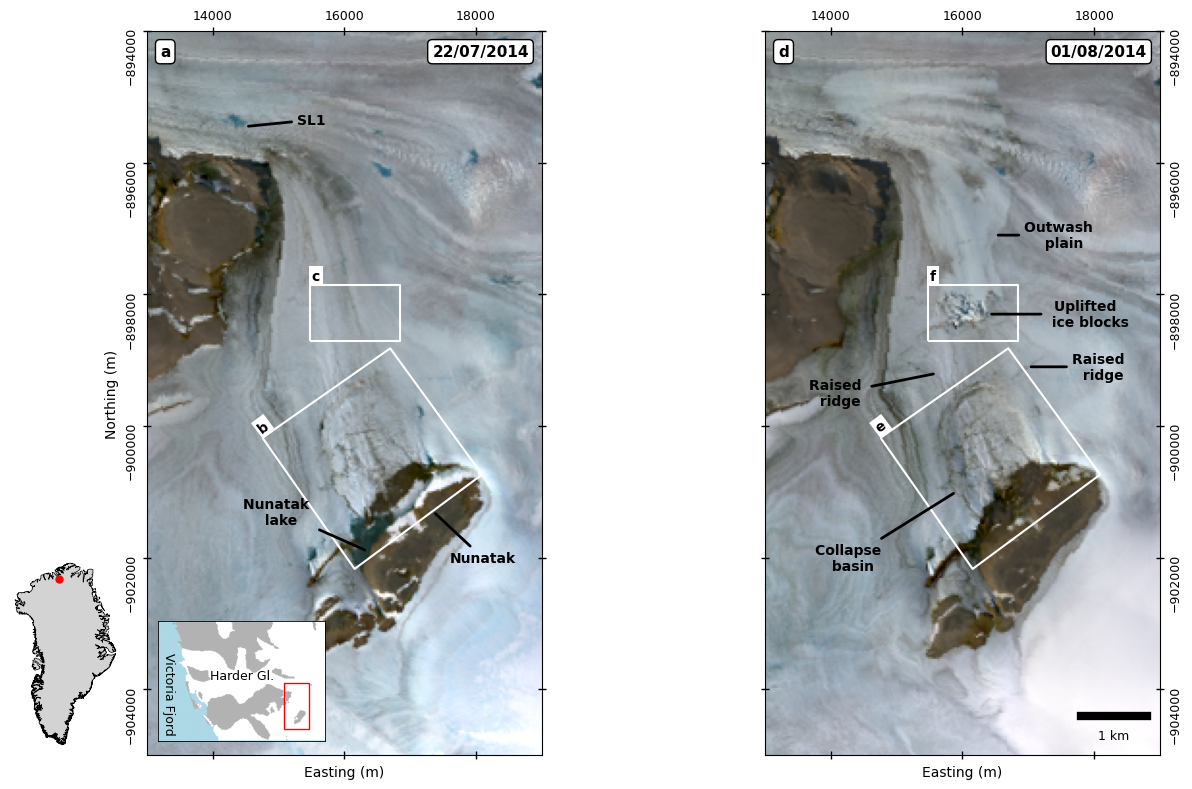

In [390]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
subplot_labels = ['a', 'd']
dates = ["22/07/2014", "01/08/2014"]

col1, col2 = [0,1]

# Load and plot DEM bounding box
basin_bbox = gpd.read_file("Data/shp/figure1_basin_bbox.shp") 
blocks_bbox = gpd.read_file("Data/shp/figure1_blocks_bbox.shp")

# Create figures 1a & d - Landsat imagery of before and after the outburst event
for i, (ax, rgb, extent, date, label) in enumerate(zip(axs, [rgb_1, rgb_2], [extent_1, extent_2], dates, subplot_labels)):
    ax.imshow(rgb, extent=extent, origin='upper')

    # Set coordinate ticks
    ax.set_xticks(create_ticks(extent[0], extent[1]))
    ax.set_yticks(create_ticks(extent[2], extent[3]))
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.tick_params(axis='both', direction='inout', length=6, width=1, colors='black', labelsize=9)
    ax.tick_params(axis='y', labelrotation=90)

    # Tick placement for subplots
    if i == 0:
        ax.tick_params(left=True, right=True, labelleft=True, labelright=False)
    else:
        ax.tick_params(left=True, right=True, labelleft=False, labelright=True)
    ax.tick_params(bottom=True, top=True, labelbottom=False, labeltop=True)

    # Axis labels
    if i == 0:
        ax.set_ylabel("Northing (m)", fontsize=10)
    ax.set_xlabel("Easting (m)", fontsize=10)

    # Set plot extent
    ax.set_xlim(minx, maxx)
    ax.set_ylim(maxy, miny)

    # Add date label (top-right)
    ax.text(
        maxx - 200, miny - 200, date,
        fontsize=11, fontweight='bold', color='black', ha='right', va='top',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

    # Add figure number (top-left)
    ax.text(
        minx + 200, miny - 200, f"{label}",
        fontsize=11, fontweight='bold', color='black', ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

    basin_bbox.plot(ax=ax, color='none', edgecolor='white', linewidth=1.5)
    blocks_bbox.plot(ax=ax, color='none', edgecolor='white', linewidth=1.5)

# Add scale bar
scalebar_length_m = 1000
bar_x_start = maxx - 1200
bar_y = maxy + 600
axs[col2].plot([bar_x_start, bar_x_start + scalebar_length_m], [bar_y, bar_y], color='black', linewidth=6)
axs[col2].text(bar_x_start + scalebar_length_m / 2, bar_y - 200, "1 km", color='black', fontsize=9, ha='center', va='top')

# Add annotations
annotations = [
    # Left subplot (axs[0])
    (axs[col1], 'SL1', (14500, -895450), (15500, -895350)),
    (axs[col1], 'Nunatak \n lake', (16350, -901900), (15000, -901300)),
    (axs[col1], 'Nunatak', (17350, -901300), (18100, -902000)),

    # Right subplot (axs[1])
    (axs[col2], 'Outwash \n plain', (16500, -897100), (17500, -897100)),
    (axs[col2], 'Uplifted \n ice blocks', (16400, -898300), (17900, -898300)),
    (axs[col2], 'Raised \n ridge', (15600, -899200), (14100, -899500)),
    (axs[col2], 'Raised \n ridge', (17000, -899100), (18100, -899100)),
    (axs[col2], 'Collapse \n basin', (15900, -901000), (14300, -902000)),
]

for ax, text, xy, xytext in annotations:
    ax.annotate(
        text, xy=xy, xytext=xytext,
        fontsize=10, fontweight='bold', color='black',
        ha='center', va='center',
        arrowprops=dict(arrowstyle='-', color='black', linewidth=2)
    )

# Add figure labels for 3D DEMs
for ax, label in zip([axs[col1], axs[col2]], ["b", "e"]):
    ax.text(
    basin_bbox.bounds['minx']-115, 
    basin_bbox.bounds['maxy']+((basin_bbox.bounds['miny']-basin_bbox.bounds['maxy'])/2)+620, 
    f"{label}",
    fontsize=10, fontweight='bold', color='black', ha='left', va='top', rotation=37,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2')
)    
    
for ax, label in zip([axs[col1], axs[col2]], ["c", "f"]):
    ax.text(
    blocks_bbox.bounds['minx']+25, blocks_bbox.bounds['maxy']+250, f"{label}",
    fontsize=10, fontweight='bold', color='black', ha='left', va='top',
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2')
)

# Add inset map
inset_ax = inset_axes(axs[col1], width="40%", height="15%", loc='lower left',
                      bbox_to_anchor=(0.02, 0.02, 1.1, 1.1), bbox_transform=axs[col1].transAxes, borderpad=0)

# Load and display Greenland ice sheet mask raster (from BedMachine)
with rasterio.open("Data/BedMachineGreenland-v5_mask_clipped.tif") as src:
    overview = src.read([1]).astype(float).transpose((1, 2, 0))
    bounds = src.bounds
    extent_inset = [bounds.left, bounds.right, bounds.bottom, bounds.top]

inset_ax.imshow(overview, extent=extent_inset, origin='upper',
                cmap=LinearSegmentedColormap.from_list("sea_ice_land", [(0, 'lightblue'), (0.3, 'darkgray'), (0.6, 'white'), (1, 'white')]))

# Draw rectangle around Figure 1a image extent
scene_box = Rectangle((minx, miny), maxx - minx, maxy - miny, linewidth=1, edgecolor='red', facecolor='none')
inset_ax.add_patch(scene_box)

# Remove ticks and style frame
inset_ax.set_xticks([]); inset_ax.set_yticks([])
for spine in inset_ax.spines.values():
    spine.set_linewidth(0.6)

# Inset labels
inset_ax.text(0.5, 0.55, "Harder Gl.", transform=inset_ax.transAxes, fontsize=9, va='center', ha='center')
inset_ax.text(0.02, 0.05, "Victoria Fjord", transform=inset_ax.transAxes, fontsize=9, va='bottom', ha='left', rotation=270)

# Greenland outline inset (in EPSG:3413)
greenland_outline_ax = fig.add_axes([-0.01, 0.05, 0.18, 0.25])  # [left, bottom, width, height] in figure fraction

# Load Greenland outline shapefile in EPSG:3413
greenland = gpd.read_file("/Users/jade/Documents/Lancaster PhD/Harder_Glacier_subglacial_outburst/AOI/greenland_outline/gl_EPSG3413.shp") 
greenland.plot(ax=greenland_outline_ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Plot red dot at scene center
scene_center_x = (minx + maxx) / 2
scene_center_y = (miny + maxy) / 2
greenland_outline_ax.plot(scene_center_x, scene_center_y, 'ro', markersize=5)

# Style adjustments
greenland_outline_ax.set_xticks([])
greenland_outline_ax.set_yticks([])
greenland_outline_ax.set_aspect('equal')

# Remove frame (spines)
for spine in greenland_outline_ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

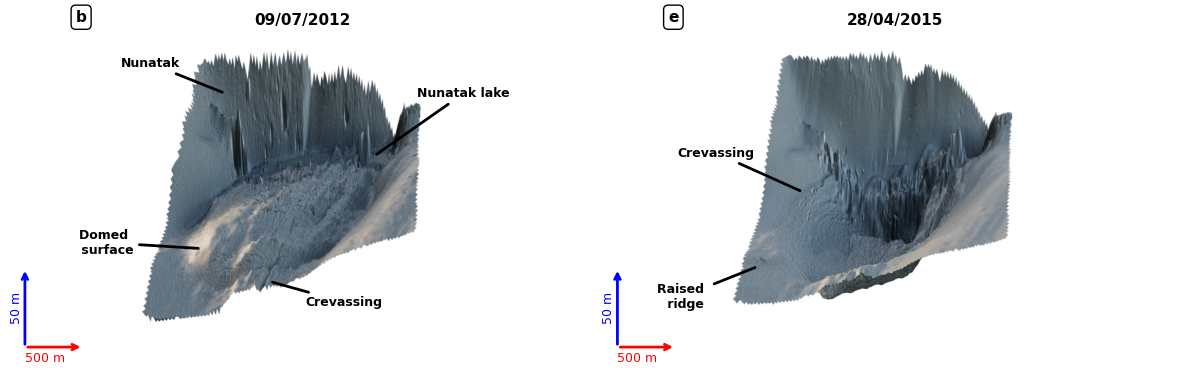

In [345]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

dem_dates = ['09/07/2012', '28/04/2015']
fig_labels = ['b', 'e']  # Figure labels

# Load images
dem_basin_2012 = imread("Data/3D DEMs/dem_20120709_basin.png")
dem_basin_2015 = imread("Data/3D DEMs/dem_20150428_basin.png")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Show images
axs[0].imshow(dem_basin_2012)
axs[1].imshow(dem_basin_2015)

annotations = [
    (axs[0], "Nunatak lake", (1200, 410), (1500, 200)),
    (axs[0], "Nunatak", (700, 200), (450, 100)),
    (axs[0], "Domed \n surface", (620, 720), (300, 700)),
    (axs[0], "Crevassing", (850, 830), (1100, 900)),
    (axs[1], "Crevassing", (650, 530), (360, 400)),
    (axs[1], "Raised \n ridge", (500, 780), (250, 880)),
]

for ax, text, xy, xytext in annotations:
    ax.annotate(
        text, xy=xy, xytext=xytext,
        fontsize=9, fontweight='bold', color='black',
        ha='center', va='center',
        arrowprops=dict(arrowstyle='-', color='black', linewidth=2)
    )

for i, ax in enumerate(axs):
    ax.set_title(dem_dates[i], fontsize=11, fontweight='bold')

    # Add figure label (top-left corner in pixel space)
    ax.text(
        200, -80, f"{fig_labels[i]}",
        fontsize=11, fontweight='bold', color='black', ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

# Real-world dimensions
real_width_m = 2452*2
real_height_m = 102*2

# Image dimensions in pixels
height_px, width_px = dem_basin_2012.shape[:2]

# Meters per pixel
meters_per_pixel_x = real_width_m / width_px
meters_per_pixel_y = real_height_m / height_px

# Convert real distances to pixel lengths
horiz_length_m = 500
vert_length_m = 50

horiz_px = horiz_length_m / meters_per_pixel_x
vert_px = vert_length_m / meters_per_pixel_y

for ax in axs:
    # Starting point for scale bars (bottom-left corner padding)
    x0 = 30
    y0 = height_px - 30

    # Draw horizontal (500 m) scale bar with arrow
    ax.annotate(
        '', xy=(x0 + horiz_px, y0), xytext=(x0, y0),
        arrowprops=dict(arrowstyle='->', color='red', linewidth=2)
    )
    ax.text(x0, y0 + 50, '500 m', color='red', fontsize=9)

    # Draw vertical (50 m) scale bar with arrow
    ax.annotate(
        '', xy=(x0, y0 - vert_px), xytext=(x0, y0),
        arrowprops=dict(arrowstyle='->', color='blue', linewidth=2)
    )
    ax.text(x0 - 50, y0 - vert_px / 2, '50 m', color='blue', fontsize=9, rotation=90, va='center')

# Remove axes for clean display
for ax in axs:
    ax.axis('off')
    
plt.tight_layout()
plt.show()

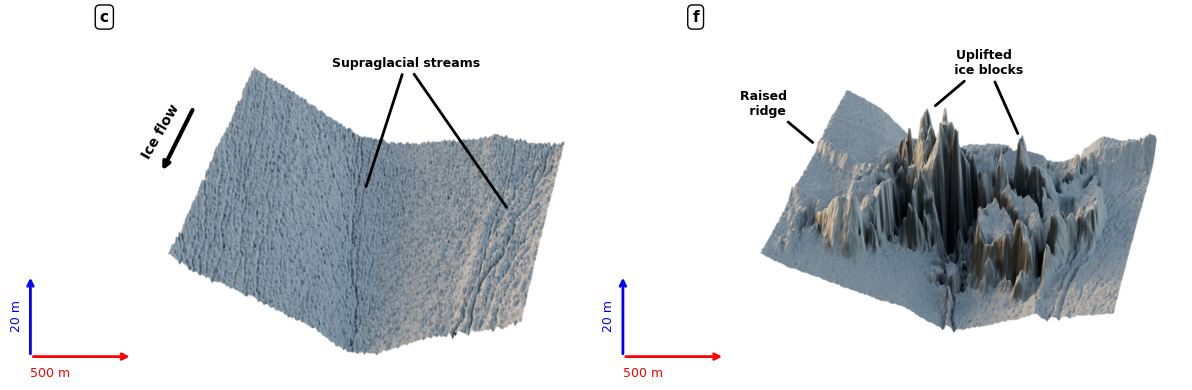

In [354]:
dem_dates = ['09/07/2012', '28/04/2015']
fig_labels = ['c', 'f']  # Figure labels

# Load images
dem_blocks_2012 = imread("Data/3D DEMs/dem_20120709_blocks.png")
dem_blocks_2015 = imread("Data/3D DEMs/dem_20150428_blocks.png")
dem_blocks_2012_crop = dem_blocks_2012[0:800, 100:1500, :]
dem_blocks_2015_crop = dem_blocks_2015[0:800, 100:1500, :]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Show images
axs[0].imshow(dem_blocks_2012_crop)
axs[1].imshow(dem_blocks_2015_crop)

annotations = [
    (axs[0], "Supraglacial streams", (850, 360), (950, 50)),
    (axs[0], "                    ", (1200, 410), (950, 50)),
    (axs[1], "Uplifted \n ice blocks", (790, 160), (920, 50)),
    (axs[1], "         \n           ", (1000, 230), (920, 50)),
    (axs[1], "Raised \n ridge", (500, 250), (380, 150))
    ]

for ax, text, xy, xytext in annotations:
    ax.annotate(
        text, xy=xy, xytext=xytext,
        fontsize=9, fontweight='bold', color='black',
        ha='center', va='center',
        arrowprops=dict(arrowstyle='-', color='black', linewidth=2)
    )

for i, ax in enumerate(axs):
    # Add figure label (top-left corner in pixel space)
    ax.text(
        200, -80, f"{fig_labels[i]}",
        fontsize=11, fontweight='bold', color='black', ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

# Ice flow
axs[0].annotate(
    '',  # No text in arrow itself
    xy=(350, 320),       # arrow end
    xytext=(430, 160),   # arrow start
    arrowprops=dict(arrowstyle='->', color='black', linewidth=3)
    )

axs[0].text(
    350, 290, "Ice flow",
    fontsize=10, fontweight='bold', color='black',
    ha='center', va='bottom', rotation=60
)
    
# Real-world dimensions
real_width_m = 1400*2
real_height_m = 40*2

# Image dimensions in pixels
height_px, width_px = dem_blocks_2012_crop.shape[:2]

# Meters per pixel
meters_per_pixel_x = real_width_m / width_px
meters_per_pixel_y = real_height_m / height_px

# Convert real distances to pixel lengths
horiz_length_m = 500
vert_length_m = 20

horiz_px = horiz_length_m / meters_per_pixel_x
vert_px = vert_length_m / meters_per_pixel_y

for ax in axs:
    # Starting point for scale bars (bottom-left corner padding)
    x0 = 30
    y0 = height_px - 30

    # Draw horizontal (500 m) scale bar with arrow
    ax.annotate(
        '', xy=(x0 + horiz_px, y0), xytext=(x0, y0),
        arrowprops=dict(arrowstyle='->', color='red', linewidth=2)
    )
    ax.text(x0, y0 + 50, '500 m', color='red', fontsize=9)

    # Draw vertical (20 m) scale bar with arrow
    ax.annotate(
        '', xy=(x0, y0 - vert_px), xytext=(x0, y0),
        arrowprops=dict(arrowstyle='->', color='blue', linewidth=2)
    )
    ax.text(x0 - 50, y0 - vert_px / 2, '20 m', color='blue', fontsize=9, rotation=90, va='center')

# Remove axes for clean display
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()